<a href="https://colab.research.google.com/github/shuvayanb/LFF-for-design-and-optimisation/blob/main/LFF_Scramjet_intake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="6">LFF: Scramjet intake</font>

This Jupyter Notebook is the working demonstration of how simple gas-dynamic relations can be cast into a low-fidelity framework for the design of scramjet intakes. The framework is an adoption of LFF approach by [reference](https://aip.scitation.org/doi/10.1063/1.4748130) and suitably alters it to account for favourable properties. The framework has been validation with existing literature [validation_1](https://aip.scitation.org/doi/10.1063/5.0006408) & [validation_2](https://www.researchgate.net/publication/349236917_Parametric_investigation_towards_the_design_of_a_scramjet_intake_using_low-fidelity_approach).  

Considering that this LFF approach is based on gas-dynamic relations, the viscous effects are not considered. Nevertheless, this framework has been evaluated with solutions from 2D Euler computations and has been found to be accurate. 

The purpose of this Notebook is to briefly demonstrate the features of the LFF approach and also to get a hands-on experience. 

![](https://raw.githubusercontent.com/shuvayanb/files_folders/main/scramjet_layout.png)

The LFF approach aims to design a mixed (external/internal) compression-based scramjet intake in hypersonic flows. It considers a scramjet intake with *n* external shocks and *m* internal shocks, with intake length *L* and height *H*, as shown in Fig. above. Simple gas dynamic relations are used to evaluate pre-post shock conditions such as:

$$\beta = \sin^{-1} \Bigg ( \sqrt{\frac{\Big ((SPR-1)(\frac{\gamma + 1}{2\gamma})\Big ) + 1)}{M^2_1}} \Bigg )$$

$$ \mathrm{   \theta} =  \mathrm{tan^{-1}} \Bigg ( 2 \ \mathrm{cot} \beta \Bigg( \frac{M_1^2 \ \mathrm{sin^2}\beta-1}{M_1^2 \ (\gamma + \mathrm{cos}2\beta)+2} \Bigg ) \Bigg ) $$

$$ M_2 =  \frac{1}{\mathrm{sin}(\beta-\theta)} \sqrt{\frac{1+\frac{\gamma-1}{2}M_1^2 \ \mathrm{sin}^2 \beta}{\gamma M_1^2 \ \mathrm{sin}^2 \beta -\frac{\gamma-1}{2}} } $$

$$ P_2 =  P_1 \Bigg( 1 + \frac{2\gamma}{\gamma+1} (M_1^2 \ \mathrm{sin}^2\beta-1) \Bigg)  $$ 

$$ \rho_2 =  \rho_1 \frac{(\gamma+1)M_1^2 \ \mathrm{sin}^2\beta}{(\gamma-1)M_1^2 \ \mathrm{sin}^2\beta+2} $$

where, $\beta$ and $\theta$ are the shock-wave and flow-deflection angle whereas $M, P, \rho$ are the Mach number, static pressure and density, respectively. Also, 1 and 2 refer to pre and post-shock conditions. 

Using this framework, we study the following quantities of interest:

$$ \mathrm{\ Static \ pressure \ ratio, \ SPR_i} = \frac{P_2}{P_1} $$

$$ \mathrm{ TPR_i} =  \frac{P_{02}}{P_2} \frac{P_{2}}{P_1} \frac{P_{1}}{P_{01}} $$

$$ \mathrm{Total \ pressure \ ratio, TPR} =  \prod_{i = 1}^{n+m} \mathrm{TPR_i}  \\ $$

$$ \mathrm{Distortion \ index, DI} =  \frac{\mathrm{max}\ (\frac{P}{P_{\infty}})}{\mathrm{min} \ (\frac{P}{P_{\infty}})} $$

$$ \mathrm{Spillage} = 1-A_1/H $$

where, $A_1$ is the intake area. Additionally, ICR is the internal contraction ratio and OCR is the overall contraction ratio. The overall LFF approach is described in the schematic below. 

![](https://raw.githubusercontent.com/shuvayanb/files_folders/main/framework_LFF.png)

Let's finally start with the framework by importing essential libraries

In [1]:
import numpy as np
import math

We will then provide some freestream conditions for the intake. Go ahead and change the existing ones as long as you are in the high-speed regime. Note that since this is an iterative scheme, we need to provide some low tolerance limit for errors. Also, since the SPR is varied in this loop, we will have to provide an initial guess to $\texttt{SPR_guess}$ as well. 

In [3]:
M1 = 5           # Freestream Mach number
Me = 0.75*M1      # Mach number after last external shock
#Mis = 0.5*M1   # Mach number at the start of the isolator
P1 = 6079.5      # Freestream Pressure
T1 = 230.0       # Freestream Temperature
R = 287.0 
rho1 = P1/(R*T1) # Freestream density
gamma_Y = 1.4;   # Ratio of specific heats

V1 = M1*np.sqrt(gamma_Y*R*T1); # Freestream velocity

H = 1          # Height of cowl lip

tol = 1e-03;
error = 100.0;

n = 4            # Number of external shocks
m = 4            # Number of internal shocks 

SPR_guess = 1.00001 # Initial guess Static Pressure Ratio

beta = [0 for i in range(n+m+1)]
theta = [0 for i in range(n+m+1)]
gam = [0 for i in range(n+m+1)]
si = [0 for i in range(n+m+2)]
M = [0 for i in range(n+m+1)]
P = [0 for i in range(n+m+1)]
T = [0 for i in range(n+m+1)]
rho = [0 for i in range(n+m+1)]

xc = [0 for i in range(n+m+1)]
yc = [0 for i in range(n+m+1)]

M[0] = M1         # Freestream Mach number
P[0] = P1         # Freestream Pressure
T[0] = T1         # Freestream Temparature
rho[0] = rho1     # Freestream density    

beta[0] = None 
theta[0] = None
gam[0] = None
si[0] = None 

After initialisation is done, we will execute the iterative scheme described in Fig. above first for the external section until the difference between the calulcated Mach number and the cowl Mach number is lower than the tolerance value. Once this is achieved, the pre and post shock conditions for the external section of the scramjet intake are obtained. We will repeat similar evaluations for the internal sections (or internal shocks) until flow at the isolator becomes parallel to the freestream direction. This makes sure that the non-uniformity at the isolator is less. 

In [4]:
while(error>tol):

    for i in range(0, n, 1): #***************External Shocks*****************//

        beta[i+1] = math.asin( np.sqrt(( ((SPR_guess-1.0)*((gamma_Y+1)/(2*gamma_Y))) + 1)/(M[i]*M[i])))

        theta[i+1] = math.atan((2*np.cos(beta[i+1])*(M[i]*M[i]*np.sin(beta[i+1])*np.sin(beta[i+1])-1))/(np.sin(beta[i+1])*(M[i]*M[i]*(gamma_Y+np.cos(2*beta[i+1]))+2)))

        M[i+1] = ((np.sqrt((M[i]*M[i]*pow(np.sin(beta[i+1]),2)+(2/(gamma_Y-1)))/ (((2*gamma_Y*M[i]*M[i]*pow(np.sin(beta[i+1]),2)/(gamma_Y-1))-1)))) / np.sin(beta[i+1]-theta[i+1]))

        if M[i+1]<1:
            print('!!! M2 is less than 1 !!!', )

        P[i+1] = (P[i] * (1 + ( ((2*gamma_Y)/(gamma_Y+1)) * (pow(M[i]*np.sin(beta[i+1]),2) -1)  )))

        rho[i+1] = rho[i] * ( ((gamma_Y+1)*M[i]*M[i]*np.sin(beta[i+1])*np.sin(beta[i+1])) / (((gamma_Y-1)*M[i]*M[i]*np.sin(beta[i+1])*np.sin(beta[i+1])) + 2)  )

        T[i+1] = T[i] * (P[i+1]/P[i]) * (rho[i]/rho[i+1])

        #gam[i+1] = beta[i+1] + theta[i+1]

        #si[i+1] = gam[i+1] - beta[i+1]


        if i==0:
            gam[i+1] = beta[i+1]
            si[i+1] = 0.0


        elif i>0:
            gam[i+1] = beta[i+1] + theta[i] + si[i]
            si[i+1] = gam[i+1] - beta[i+1]


    SPR_guess = SPR_guess + 0.00001

    error = abs(Me-M[n])
    
sum_ext=0

for i in range(0, n, 1):

    sum_ext+=theta[i+1]


ext_guess_PR = SPR_guess - 0.00001

error = 100.0

SPR_guess = 1.00001

temp = 0.0


while(error>tol):

    for i in range(0, m, 1): #***************Internal Shocks*****************//
         
        beta[n+i+1] = math.asin( np.sqrt(( ((SPR_guess-1.0)*((gamma_Y+1)/(2*gamma_Y))) + 1)/(M[n+i]*M[n+i])))

        theta[n+i+1] = math.atan((2*np.cos(beta[n+i+1])*(M[n+i]*M[n+i]*np.sin(beta[n+i+1])*np.sin(beta[n+i+1])-1))/(np.sin(beta[n+i+1])*(M[n+i]*M[n+i]*(gamma_Y+np.cos(2*beta[n+i+1]))+2)))

        M[n+i+1] = (np.sqrt((M[n+i]*M[n+i]*pow(np.sin(beta[n+i+1]),2)+(2/(gamma_Y-1)))/ (((2*gamma_Y*M[n+i]*M[n+i]*pow(np.sin(beta[n+i+1]),2)/(gamma_Y-1))-1)))) / np.sin(beta[n+i+1]-theta[n+i+1] )

        P[n+i+1] = P[n+i] * (1 + ( ((2*gamma_Y)/(gamma_Y+1)) * (pow(M[n+i]*np.sin(beta[n+i+1]),2) -1)  ))

        rho[n+i+1] = rho[n+i] * (  ((gamma_Y+1)*M[n+i]*M[n+i]*np.sin(beta[n+i+1])*np.sin(beta[n+i+1])) / (((gamma_Y-1)*M[n+i]*M[n+i]*np.sin(beta[n+i+1])*np.sin(beta[n+i+1])) + 2)  )

        T[n+i+1] = T[n+i] * (P[n+i+1]/P[n+i]) * (rho[n+i]/rho[n+i+1])


    sum_int=0;

    for i in range(0, m, 1):
        sum_int+=theta[n+i+1]
    
    si[n+m+1] = 0

    for i in range(m, 0, -1):

        si[n+i] = si[n+i+1] + theta[n+i]
        gam[n+i] = beta[n+i] - si[n+i]
        
    

    SPR_guess = SPR_guess + 0.00001

    error = abs(sum_ext-sum_int)

int_guess_PR = SPR_guess - 0.00001;

#print([si[-1],gam[-1],M[-1],T[-1],P[-1]])
#print(si)
#print(gam)


We have now completed the crux of the computations. $i.e.,$ the pre and post shock conditions for the entire scramjet intake are obtained such that all the external shocks emanating from the leading-edge hits the cowl edge ($\textit{i.e.,}$ shock-on-lip) and all the internal shocks originating from the cowl hits the ramp shoulder ($\textit{i.e.,}$ shock-on-shoulder) condition. The first condition makes sure that the loss due to spillage is minimum whereas the latter ensures that the flow non-uniformity at the isolator is low. Now we will perform some trigonometric computations to determine how the shock form in relation to the scramjet configuration. 

In [5]:
#Scramjet shape
 
#***************** Trigonometric calculations ********************
              

X = [0 for i in range(n+m+1)]
Y = [0 for i in range(n+m+1)]

X[n+1] = 0
Y[n+1] = 0

y = 0.0;
x = 0.0;

X[0] = 0.0;
Y[0] = 0.0;


for i in range(1,n+1,i):

    if(i==1):
        j=i-1;


    elif(i!=1):
        j=i;


    while(y<=H):

        y = Y[j] + ( (x-X[j]) * np.tan(gam[i]) );
        x = x + 0.001;


    if(i==1):

        gg = x
        X[i] = gg

        gg = y
        Y[i] = gg
        

    x = X[j]

    if(i!=n):
        temp = ((Y[1]-Y[j]) - (X[1]*np.tan(gam[i+1])) + (X[j]*np.tan(si[i]+theta[i])) ) / (  np.tan(si[i]+theta[i]) - np.tan(gam[i+1]))
    

    else:  #because the shock changes to internal and hence gamma becomes negative  
        temp = ((Y[1]-Y[j]) - (X[1]*np.tan(-gam[i+1])) + (X[j]*np.tan(si[i]+theta[i])) ) / (  np.tan(si[i]+theta[i]) - np.tan(-gam[i+1]))


    while(x<=temp):

        y = Y[j] + ( (x-X[j])*(np.tan(theta[i]+si[i])));
        x = x + 0.001;
        

    gg = x;
    X[i+1] = gg;

    gg = y;
    Y[i+1] = gg;


#print([temp,X[1],Y[1],X[2],Y[2],X[3],Y[3],X[4],Y[4],gam[1],gam[2],gam[3],gam[4],si[1],si[2],si[3],si[4],gg])

x = X[1]

while(x<=X[n+1]): # for the  first internal shock

    y = Y[n+1] + ( (x-X[n+1])*np.tan(-gam[n+1]) );

    x = x + 0.001;



for i in range(1,m,1):  # for the remaining internal shocks
   
    x=X[n+1];

    if(i==1): #because in the first case the cowl starts with (X[1],Y[1])
        temp = (Y[n+1] - Y[1] + X[1]*np.tan(si[n+i+1]) - X[n+1]*np.tan(-gam[n+i+1]))/(np.tan(si[n+i+1]) - np.tan(-gam[n+i+1]));

    else:
        temp = (Y[n+1] - Y[n+i] + X[n+i]*np.tan(si[n+i+1]) - X[n+1]*np.tan(-gam[n+i+1]))/(np.tan(si[n+i+1]) - np.tan(-gam[n+i+1]));


    while(x>=temp):

        y = Y[n+1] + ((x-X[n+1])*np.tan(-gam[n+i+1]))

        x = x - 0.001;



    X[n+i+1] = x

    Y[n+i+1] = y

    if(i==1): #because in the first case the cowl starts with (X[1],Y[1])

        x = X[1]

        while(x<=X[n+i+1]):

            y = Y[1] + ((x-X[1])*np.tan(si[n+i+1]));
            x = x + 0.001;

    else:
        x=X[n+i];

        while(x<=X[n+i+1]):

            y = Y[n+i] + ((x-X[n+i])*np.tan(si[n+i+1]));
            x = x + 0.001;


X[n+m] = x

Y[n+m] = y


The next module is meant for the estimation of the point of intersection of the normals dropped from the cowl onto the scramjet ramp. This aids in the calculation of cowl area, $A_c$. 

In [6]:
#phi_calc()
 
#*************************** Calculation for calculation of phi_x and phi_y points, which are normals dropped on to the ramp from cowl lip ****************************/////


xo = X[1]    # coordinates of the Cowl lip
yo = Y[1]


x_1 = X[n]   # coordinates of the last ramp onto which the normal from the cowl lip is to be dropped
x_2 = X[n+1]
y_1 = Y[n]
y_2 = Y[n+1]

if(n==1):     # Exception 
    
    x_1 = X[0]
    x_2 = X[n+1]
    y_1 = Y[0]
    y_2 = Y[n+1]


t = (y_2-y_1)*(yo-y_1)+(x_2-x_1)*(xo-x_1)
t = t/(pow((y_2-y_1),2)+pow((x_2-x_1),2))

if((t<0)and(t>1)):
    if(t>1):
        t=1
    else:
        t=0


phi_x=x_1+t*(x_2-x_1) # Coordinates of the intersection of the normal dropped from cowl lip to the last ramp  
phi_y=y_1+t*(y_2-y_1) 


if(m==1):

    At = H-Y[n+1]

    Ac = sqrt(pow((X[1]-phi_x),2) + pow((Y[1]-phi_y),2) ) 

    Ai = H

    As = sqrt(pow((X[1]-X[n+1]),2) + pow((Y[1]-Y[n+1]),2) ) 


elif(m>=2):

    At = Y[n+m]-Y[n+1]

    Ac = np.sqrt(pow((X[1]-phi_x),2) + pow((Y[1]-phi_y),2) ) 

    Ai = H


At_Ai = (At/Ac)*(np.sin(beta[n]-theta[n])/ np.sin(beta[1]))

Lmax = X[n+m] + 0.25 * X[n+m]


We will now get to see how the shocks form in relation to the scramjet intake configuration. 

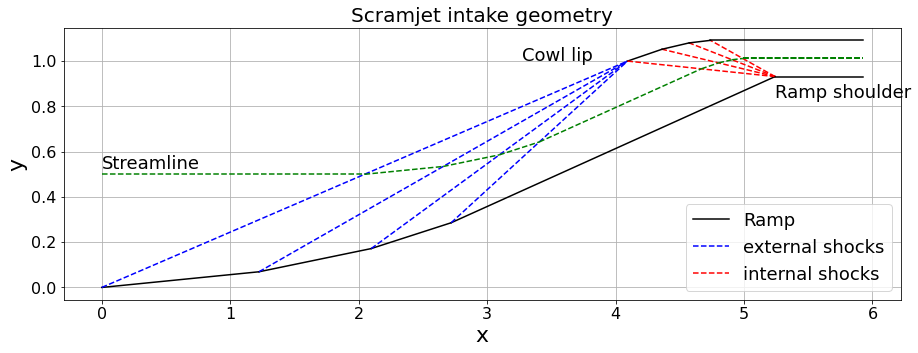

In [8]:
#plotting

def drawArrow(A, B):
    arrow = plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],
                      head_width=0.0075, length_includes_head=True)
    return arrow

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as font_manager

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

import pylab
import numpy as np

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(15, 5))

for i in range(0,n,1): # external ramps (black) & external shocks (blue)
  if i==0:
    plt.plot([X[i],X[i+2]],[Y[i],Y[i+2]], 'k', linestyle="-",label='Ramp')
    plt.plot([X[i],X[1]],[Y[i],Y[1]], 'b', linestyle="--",label='external shocks')

  elif(i>0):
    plt.plot([X[i+1],X[i+2]],[Y[i+1],Y[i+2]], 'k', linestyle="-")
    plt.plot([X[i+1],X[1]],[Y[i+1],Y[1]], 'b', linestyle="--")


for i in range(n,n+m,1): # internal shocks (red)
  if i==n:
    plt.plot([X[1],X[i+2]],[Y[1],Y[i+2]], 'k', linestyle="-")

  elif(i>n):
    plt.plot([X[n+1],X[i+1]],[Y[n+1],Y[i+1]], 'r', linestyle="--")
    

for i in range(n,n+m,1): # cowl body
  if i==n:
    plt.plot([X[1],X[i+1]],[Y[1],Y[i+1]], 'r', linestyle="--",label='internal shocks')

  elif(i>n+1):
    plt.plot([X[i],X[i+1]],[Y[i],Y[i+1]], 'k', linestyle="-")
    

plt.plot([X[n+1],Lmax],[Y[n+1],Y[n+1]], 'k', linestyle="-")
#plt.plot([Lmax,Lmax],[Y[n+1],Y[n+m]], 'k', linestyle="-")
plt.plot([Lmax,X[n+m]],[Y[n+m],Y[n+m]], 'k', linestyle="-")

cowl = [xo,yo]
phi_b = [phi_x,phi_y]

#arrow = drawArrow(cowl,phi_b)

#print('The perpendicular dropped from the cowl to the ramp body may not appear as normals due to aspect ratio of the image ')

plt.title('Scramjet intake geometry', fontsize = 20)    
plt.xlabel('x',fontsize=22)
plt.ylabel('y',fontsize=22)
plt.tick_params(labelsize=16)
#plt.xlim(-0.05, 1.2)
#plt.ylim(-0.01, 0.14)
plt.legend(loc="lower right")
plt.grid(True, which="both", ls="-")

plt.text(X[n+1],Y[n+1]*0.9, "Ramp shoulder")

#plt.text(phi_x*1.025,phi_y*0.9, "Normals dropped from cowl")

plt.text(X[1]*0.8,Y[1], "Cowl lip")


def intersection(m1,m2,xo,yo,xc,yc):
    xi = ((yo-yc) + (m2*xc) - (m1*xo))/ (m2-m1)
    yi = m1 * (xi-xo) + yo
    
    return xi,yi


xc[0] = 0
yc[0] = H*0.5

for i in range(0,n,1):
    
    if i==0:
        m1 = (Y[1]-Y[0])/(X[1]-X[0])
        m2 = 0
        xc[i+1],yc[i+1] = intersection(m1,m2,X[i],Y[i],xc[i],yc[i]) 
        plt.plot([xc[i],xc[i+1]],[yc[i],yc[i+1]], 'green', linestyle="--")
        
    elif i==1:
        m1 = (Y[1]-Y[i+1])/(X[1]-X[i+1])
        m2 = (Y[i+1]-Y[i-1])/(X[i+1]-X[i-1])
        xc[i+1],yc[i+1] = intersection(m1,m2,X[i],Y[i],xc[i],yc[i])
        plt.plot([xc[i],xc[i+1]],[yc[i],yc[i+1]], 'green', linestyle="--")
        
    elif i>1:
        m1 = (Y[1]-Y[i+1])/(X[1]-X[i+1])
        m2 = (Y[i+1]-Y[i])/(X[i+1]-X[i])
        xc[i+1],yc[i+1] = intersection(m1,m2,X[i+1],Y[i+1],xc[i],yc[i])
        plt.plot([xc[i],xc[i+1]],[yc[i],yc[i+1]], 'green', linestyle="--")
#    print(xc[i+1],yc[i+1],m1,m2)    
        
        
for i in range(n,n+m,1):
    
    if i==n:
        m1 = (Y[1]-Y[n+1])/(X[1]-X[n+1])
        m2 = (Y[i+1]-Y[i])/(X[i+1]-X[i])
        xc[i+1],yc[i+1] = intersection(m1,m2,X[i+1],Y[i+1],xc[i],yc[i])
        plt.plot([xc[i],xc[i+1]],[yc[i],yc[i+1]], 'green', linestyle="--")

        
    if i>n:
        if m==1:
            m1 = (Y[i+1]-Y[n+1])/(X[i+1]-X[n+1])
            m2 = (Y[i+1]-Y[1])/(X[i+1]-X[1])

        elif i==n+1:    
            m1 = (Y[i+1]-Y[n+1])/(X[i+1]-X[n+1])
            m2 = (Y[i+1]-Y[1])/(X[i+1]-X[1]) #5 - 1

        elif i>n+1:   
            m1 = (Y[i+1]-Y[n+1])/(X[i+1]-X[n+1])
            m2 = (Y[i+1]-Y[i])/(X[i+1]-X[i]) 

            
        xc[i+1],yc[i+1] = intersection(m1,m2,X[n+1],Y[n+1],xc[i],yc[i])
        plt.plot([xc[i],xc[i+1]],[yc[i],yc[i+1]], 'green', linestyle="--")

    #print(i,i+1,xc[i+1],yc[i+1],m1,m2)

    plt.plot([xc[n+m],Lmax],[yc[n+m],yc[n+m]], 'green', linestyle="--")

#print(X[n+m],Y[n+m])
plt.text(xc[0],yc[0]*1.05, "Streamline");

We will now evaluate some constants that inform us of the area ratio. These steps are crucial from the point of view of the unstart phenomenon of scrmajets. 

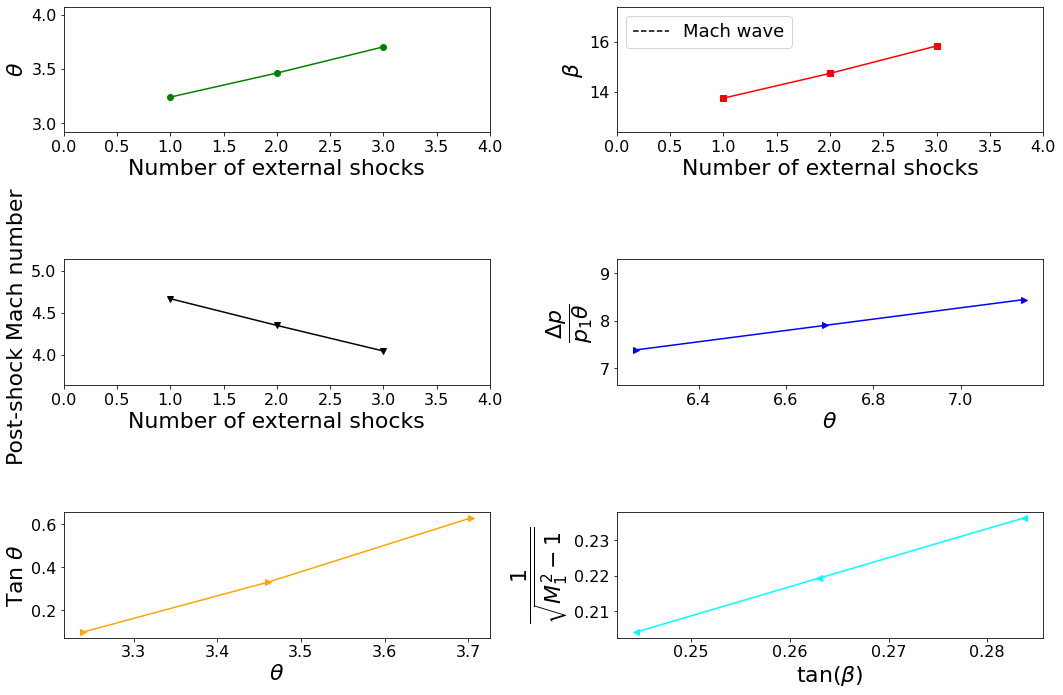

In [9]:
list_theta = []
list_tan_theta = []
list_beta = []
list_Mach = []
list_pressure = []
list_index = []
list_Msin = []
list_din = []
list_frac = []
list_tanbeta = []

sum_theta = 0.0

for i in range(1,n,1):
    list_theta.append(theta[i]*180/3.14159)
    list_tan_theta.append(math.tan(theta[i]*180/3.14159))
    list_beta.append(beta[i]*180/3.14159)
    list_Mach.append(M[i])
    list_pressure.append((P[i]-P[i-1])/(P[i-1]*theta[i]))
    list_Msin.append(((M[i]*math.sin(beta[i]))**2)-1)
    list_tanbeta.append(math.tan(beta[i]))
    list_din.append(1/(np.sqrt((M[i-1]*M[i-1])-1)))
    list_frac.append( (gamma_Y * M[i-1]* M[i-1])/ (np.sqrt(M[i-1]*M[i-1]-1)) )
    list_index.append(i)
    sum_theta = sum_theta+theta[i]


Mach_wave = math.asin(1/M1)

fig, axs = plt.subplots(3, 2,figsize=(15,10))

axs[0, 0].set_xlim([0, n])
axs[0, 0].set_ylim([min(list_theta) - 0.1* min(list_theta), max(list_theta) + 0.1* max(list_theta)])
axs[0, 0].set_xlabel('Number of external shocks',fontsize=22)
axs[0, 0].set_ylabel(r'$\theta$',fontsize=22)
axs[0, 0].tick_params(labelsize=16)
axs[0, 0].plot(list_index,list_theta, color='green', marker='o')

axs[0, 1].set_xlim([0, n])
axs[0, 1].set_ylim([min(list_beta) - 0.1* min(list_beta), max(list_beta) + 0.1* max(list_beta)])
axs[0, 1].set_xlabel('Number of external shocks',fontsize=22)
axs[0, 1].set_ylabel(r'$\beta$',fontsize=22)
axs[0, 1].tick_params(labelsize=16)
axs[0, 1].plot(list_index,list_beta, color='red', marker='s')
axs[0, 1].axhline(y=Mach_wave*180/np.pi, color='k', linestyle='--',label='Mach wave')
axs[0, 1].legend(loc="upper left")

axs[1, 0].set_xlim([0, n])
axs[1, 0].set_ylim([min(list_Mach) - 0.1* min(list_Mach), max(list_Mach) + 0.1* max(list_Mach)])
axs[1, 0].set_xlabel('Number of external shocks',fontsize=22)
axs[1, 0].set_ylabel('Post-shock Mach number ',fontsize=22)
axs[1, 0].tick_params(labelsize=16)
axs[1, 0].plot(list_index,list_Mach, color='black', marker='v')

#axs[1, 1].set_xlim([0, n])
axs[1, 1].set_ylim([min(list_pressure) - 0.1* min(list_pressure), max(list_pressure) + 0.1* max(list_pressure)])
axs[1, 1].set_xlabel(r'$\theta$',fontsize=22)
axs[1, 1].set_ylabel(r'$\dfrac{\Delta p}{p_1\theta } $',fontsize=22)
axs[1, 1].tick_params(labelsize=16)
axs[1, 1].plot(list_frac,list_pressure, color='blue', marker='>')

#axs[2, 0].set_xlim([0, n])
#axs[2, 0].set_ylim([min(list_pressure) - 0.1* min(list_pressure), max(list_pressure) + 0.1* max(list_pressure)])
axs[2, 0].set_xlabel(r'$\theta$',fontsize=22)
axs[2, 0].set_ylabel(r'Tan $\theta$ ',fontsize=22)
axs[2, 0].tick_params(labelsize=16)
axs[2, 0].plot(list_theta,list_tan_theta, color='orange', marker='>')

axs[2, 1].set_xlabel(r'tan($ \beta$)',fontsize=22)
axs[2, 1].set_ylabel('$\dfrac{1}{\sqrt{M^2_1 - 1}}$',fontsize=22)
axs[2, 1].tick_params(labelsize=16)
#axs[2, 1].plot(list_Msin,list_Mtan, color='cyan', marker='<')
axs[2, 1].plot(list_tanbeta,list_din, color='cyan', marker='<')


fig.tight_layout()
plt.show()



Finally, we will now evaluate the various quantities of interest such as TPR, SPR, OCR, ICR etc. 

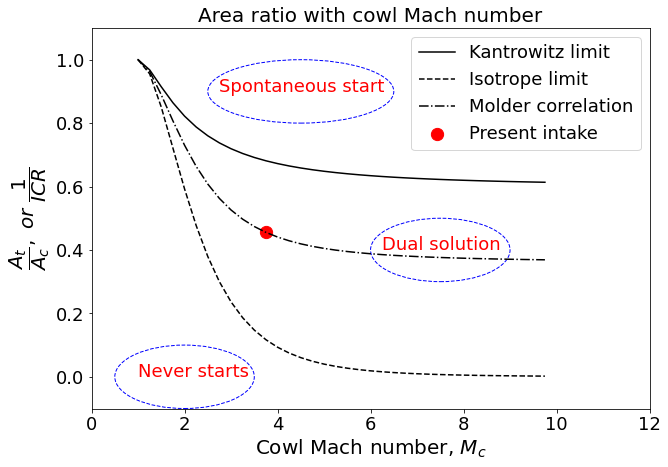

In [10]:
# Start / Unstart from area ratio

from matplotlib import patches
from matplotlib.patches import Ellipse


# OCR, Overall Contraction ratio, as defined in Veillard et al. 08, JPP : i.e. ratio of Ainf to Ath 
# ICR, Internal Contraction ratio, as defined in Veillard et al. 08, JPP : i.e. ratio of Acowl to Ath

OCR = Ai/At # Overall contraction ratio

ICR = Ac/At # Internal contraction ratio



def area_ratio(M_temp):
    
    M_c = M_temp

    temp1 = ((gamma_Y+1)*M_c*M_c)/(((gamma_Y-1)*M_c*M_c) + 2);
    temp2 = pow(temp1,(gamma_Y/(gamma_Y-1)));
    temp3 = temp2/M_c;
    temp1 = (gamma_Y+1)/((2*gamma_Y*M_c*M_c)-(gamma_Y-1));
    temp2 = pow(temp1,(1/(gamma_Y-1)));
    temp1 = (2+((gamma_Y-1)*M_c*M_c))/(gamma_Y+1);
    temp4 = pow(temp1,((gamma_Y+1)/(2*(gamma_Y-1))));

    temp_Kl = temp3*temp2*temp4; # Kantrowitz limit

    temp1 = (2/(gamma_Y+1))*(1+((gamma_Y-1)*0.5*M_c*M_c))
    temp2 = pow(temp1,((gamma_Y+1)/(2*(gamma_Y-1))))

    temp_iso = temp2/M_c # Isothermal limit
    
    S = 0.6;

    temp_molder = 1/ ((S/temp_Kl) + ((1-S)/temp_iso))    

    return temp_Kl,temp_iso,temp_molder

plt.figure(figsize=(10, 7))
ax = plt.gca()

Kw = []
iso = []
molder = []
index = []

for i in np.arange(1.0,10.0,0.25):
    K, iss, ml = area_ratio(i)
    
    Kw.append(1/K)
    iso.append(1/iss)
    molder.append(1/ml)
    index.append(i)

plt.xlim([0, 12])
plt.ylim([-0.1, 1.1])

plt.plot(index,Kw, 'k', linestyle="-", label='Kantrowitz limit')
plt.plot(index,iso, 'k', linestyle="--", label='Isotrope limit')
plt.plot(index,molder, 'k', linestyle="-.", label='Molder correlation')
plt.scatter(M[n],1/ICR, s=150, marker='o',c='r', label = 'Present intake')

ellipse1 = Ellipse((7.5, 0.4), 3.0, 0.2,
                     angle=0, linewidth=1, fill=False, zorder=2, edgecolor='b',linestyle='--')

ax.add_patch(ellipse1)


plt.text(6.25,0.4, "Dual solution", c='r')


ellipse2 = Ellipse((4.5, 0.9), 4.0, 0.2,
                     angle=0, linewidth=1, fill=False, zorder=2, edgecolor='b',linestyle='--')

ax.add_patch(ellipse2)
plt.text(2.75,0.9, "Spontaneous start", c='r')

ellipse3 = Ellipse((2.0, 0.0), 3.0, 0.2,
                     angle=0, linewidth=1, fill=False, zorder=2, edgecolor='b',linestyle='--')

ax.add_patch(ellipse3)
plt.text(1.0,0.0, "Never starts", c='r')


plt.title('Area ratio with cowl Mach number', fontsize = 20)    
plt.xlabel('Cowl Mach number, $M_c$',fontsize=20)
plt.ylabel('$ \dfrac{A_t}{A_c},\ or \ \dfrac{1}{ICR}$',fontsize=20)
plt.tick_params(labelsize=18)
plt.legend(loc="upper right")



plt.show()




In [11]:
#Additional flow parameters


# TPR, Total Pressure Recovery, as defined by Raj and Venkatasubbiah 2012, PoF : i.e. P02/P01 = (P02/P2)*(P2/P1)*(P1/P01)

# SPR, Static Pressure Ratio, as defined by Raj and Venkatasubbiah 2012, PoF : i.e. ratio of isolator static pressure to freestream static pressure, P2/P1
# SPR, is also same as Compression Ratio, as defined by Smart 2012, AIAA : 	 i.e. ratio of isolator static pressure to freestream static pressure, P2/P1

# KE_ad_1, Adiabatic Kinetic Energy, as defined by Waltrup et al. 1982, AGARD
# KE_ad_2, Adiabatic Kinetic Energy, as available in Smart 2012, AIAA



TPR = [0 for i in range(n+m+1)]

for i in range(1,n+1,1):

    temp1 = 1 + ((gamma_Y-1)*0.5*pow(M[i],2))
    temp1 = pow(temp1,(gamma_Y/(gamma_Y-1)))

    temp2 = 1 + ((2*gamma_Y)/(gamma_Y+1))*(pow(M[i-1]*np.sin(beta[i]),2)-1)

    temp3 = 1 + ((gamma_Y-1)*0.5*pow(M[i-1],2))
    temp3 = pow(temp3,(-gamma_Y/(gamma_Y-1)))

    TPR[i] = temp1*temp2*temp3 # Total Pressure Ratio across a single shock


for i in range(n+1,n+m+1,1):
    temp1 = 1 + ((gamma_Y-1)*0.5*pow(M[i],2))
    temp1 = pow(temp1,(gamma_Y/(gamma_Y-1)))

    temp2 = 1 + ((2*gamma_Y)/(gamma_Y+1))*(pow(M[i-1]*np.sin(beta[i]),2)-1)

    temp3 = 1 + ((gamma_Y-1)*0.5*pow(M[i-1],2))
    temp3 = pow(temp3,(-gamma_Y/(gamma_Y-1)))

    TPR[i] = temp1*temp2*temp3 # Total Pressure Ratio across a single shock



TPR_tot=1.0;

for i in range(1,n+m+1,i):

    TPR_tot=TPR_tot*TPR[i]


TP_recovery = TPR_tot

SPR =  P[n+m]/P[0]

KE_ad_1 = 1-(0.4* (pow (1-(M[n+m]/M[0]),4))   )

KE_ad_2 = 1-((pow(9/M[0],0.7))*((0.018*(1-(M[n+m]/M[0])))+(0.12*(pow((1-(M[n+m]/M[0])),4)))))

eta_B = ((T[0]*(pow((P[n+m]/P[0]), (gamma_Y-1)/gamma_Y))) - T[0])/(T[n+m]-T[0]) # Compression as defined in ogawa and Boyce 2012, AIAA


print(' Total pressure recovery is : {:0.5}' .format(TP_recovery))

print(' Static pressure ratio is : {:0.5}' .format(SPR))

print('\n Overall contraction ratio and Internal contraction ratio are: {:0.5} and {:0.5} ' .format(1/OCR,1/ICR))

print('\n Compression efficiency, eta_B: {:0.5}'.format(eta_B*100))

print(' Kinetic energy efficiency 1 and 2 are: {:0.5} and {:0.5}'.format(KE_ad_1*100, KE_ad_2*100))

print('\n Exit flow properties:\n')

print(' Mach number, M: {:0.5}'.format(M[n+m]))

print(' Temperature number, T: {:0.5} in [K]' .format(T[n+m]))

print(' Pressure number, P: {:0.5} in [Pa]' .format(P[n+m]))


 Total pressure recovery is : 0.99397
 Static pressure ratio is : 16.031

 Overall contraction ratio and Internal contraction ratio are: 0.16006 and 0.45553 

 Compression efficiency, eta_B: 98.169
 Kinetic energy efficiency 1 and 2 are: 98.768 and 98.304

 Exit flow properties:

 Mach number, M: 2.9054
 Temperature number, T: 513.35 in [K]
 Pressure number, P: 9.7461e+04 in [Pa]


We recommend to alter the number of internal and external shocks and see how the properties change. For some values, the ICR (or OCR) values may exceed the Kantrowitz limit. 

For more information, feel free to follow through these manuscripts.:

1. Brahmachary, S., Chutia, J., Natarajan, G., Kulkarni, V., and Sahoo, N, “Parametric investigation towards the design of a scramjet intake using low-fidelity approach”, *Proceedings of the 8th International and 47th National Conference on Fluid Mechanics and Fluid Power (FMFP)* December 9-11, 2020 IIT Guwahati, Assam, India

2. Brahmachary, S., Natarajan, G., Kulkarni, V., and Sahoo, N.,"Comment on ‘A new approach for the design of hypersonic scramjet inlets’". *Physics of Fluids*, 2020